In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

import seaborn as sns

sns.set_context('notebook', font_scale=1.5)
sns.set_style('darkgrid', rc={'ytick.left':True, 'ytick.direction':'in',
                              'xtick.bottom':True, 'xtick.direction':'in'})

In [2]:
# init_df - датафрейм в исходном виде
init_df = pd.read_csv('datasets/games.csv')

# df - датафрейм для преобразований
df = pd.read_csv('datasets/games.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


## Шаг 1. Подготовка данных.

In [4]:
# Привожу названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [5]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Год выпуска не указан менее чем в 2% случаев, тратить время на их заполнение неэффективно. А вот с `user_score` придется поразбираться:

In [6]:
# Строки с подозриельтым значением
df[df['user_score']=='tbd'].shape

(2424, 11)

Интернет сообщает, что отметка `tbd` выставляется в рейтенге у игр, на которые еще не собрано достаточно отзывов. Заменю эти значения на NaN, поскольку они ненесут для меня полезной информации:

In [7]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

df['year_of_release'] = df['year_of_release'].astype('Int64')

# Проверка
print(df['user_score'].dtype, df['year_of_release'].dtype)

float64 Int64


In [8]:
# Cуммарные продажи во всех регионах
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales']

# Проверка
df[['na_sales', 'eu_sales', 'jp_sales', 'total_sales']].head()

,na_sales,eu_sales,jp_sales,total_sales
0,41.36,28.96,3.77,74.09
1,29.08,3.58,6.81,39.47
2,15.68,12.76,3.79,32.23
3,15.61,10.93,3.28,29.82
4,11.27,8.89,10.22,30.38


#### Статистика по годам

_Количество выпущенных игр_

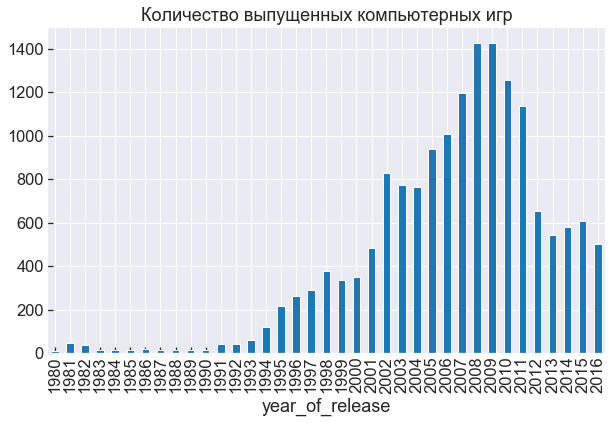

In [9]:
df.groupby('year_of_release')['name'].count().plot.bar()

plt.title('Количество выпущенных компьютерных игр')

plt.show()

Игры, выпущенные раньше 1991 года можно будет объеденить в одну группу. Их количество исчезающе мало по сравнению с периодом после. Наблюдается подозрительный спад количества выпускаемых игр начиная с 2009 года. Вряд ли игр стали выпускать существенно меньше, похоже на особенность датасета.

_Продажи на разных платформах_

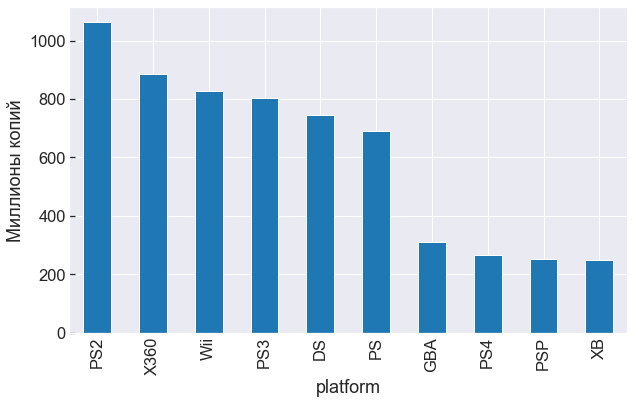

In [10]:
# Выберите платформы с наибольшими суммарными продажами
top_sales_platforms = df.groupby('platform')['total_sales'].sum().nlargest(10)

plt.ylabel('Миллионы копий')

top_sales_platforms.plot.bar()

plt.show()

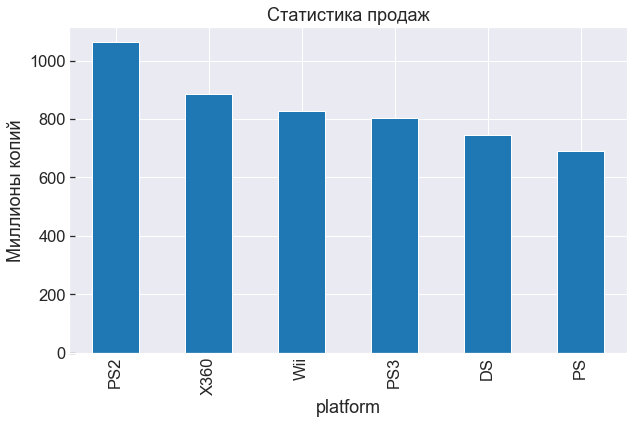

In [11]:
# Ограничусь шестью самыми крупными по прадажам
top_sales_platforms = df.groupby('platform')['total_sales'].sum().nlargest(6)

plt.ylabel('Миллионы копий')
plt.title('Статистика продаж')

top_sales_platforms.plot.bar()

plt.show()

In [12]:
top_names = list(top_sales_platforms.index)
# Добавляю PC для сравнения
top_names.append('PC')

print(top_names)

top_sales_df = df[df['platform'].isin(top_names)]

top_sales_df.shape

['PS2', 'X360', 'Wii', 'PS3', 'DS', 'PS', 'PC']


(10396, 12)

In [13]:
top_sales_groups = top_sales_df.groupby(['platform', 'year_of_release'])['total_sales'].agg(('sum'))

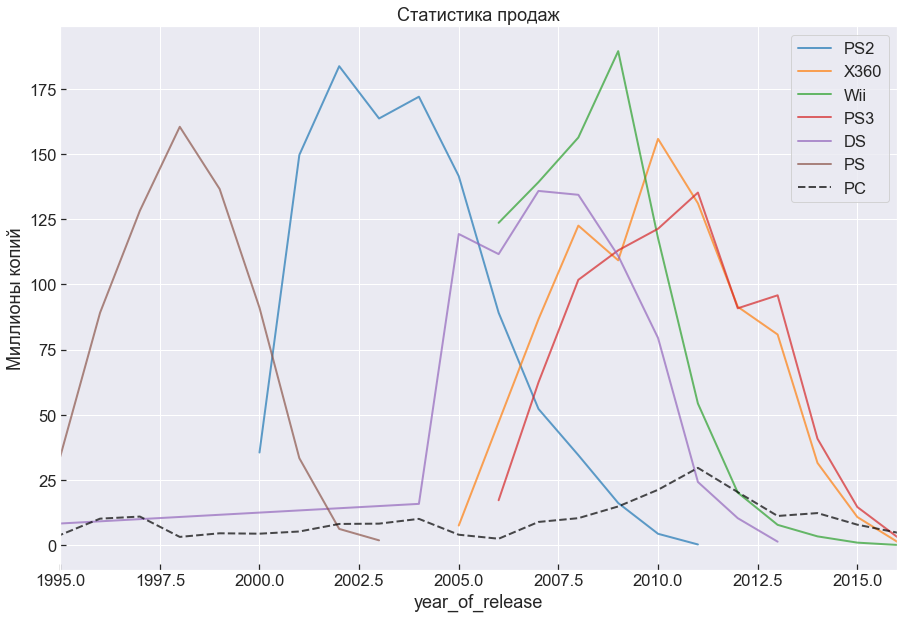

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))

for platform_name in top_sales_platforms.index:

    stat_df = top_sales_groups.loc[[platform_name]].reset_index(level=0, drop=True)

    stat_df.plot(ax=ax, alpha=.7, lw=2, label=platform_name)

stat_df = top_sales_groups.loc[['PC']].reset_index(level=0, drop=True)
stat_df.plot(ax=ax, alpha=.7, lw=2, label='PC', color='k', ls='--')

plt.ylabel('Миллионы копий')
plt.title('Статистика продаж')

plt.xlim(1995, 2016)
plt.legend()
plt.show()

***

In [22]:
df[df['name']=='Half-Life 2']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
665,Half-Life 2,PC,2004,Shooter,2.28,0.02,0.08,0.00,96.0,9.1,M,2.38
3298,Half-Life 2,XB,2005,Shooter,0.37,0.21,0.00,0.03,90.0,8.6,M,0.58


***

In [35]:
pc_df = df[df['platform']=='PC']

pc_names = pc_df['name']

non_pc_sales = df[df['name'].isin(pc_names) & (df['platform'] != 'PC')]

non_pc_stat = non_pc_sales.groupby(['name'])['total_sales'].sum()

non_pc_stat

name
007: Quantum of Solace              3.17
Agatha Christie: The ABC Murders    0.09
Air Conflicts: Secret Wars          0.24
Alan Wake                           1.21
Alice: Madness Returns              0.95
                                    ... 
XCOM 2                              0.16
XCOM: Enemy Unknown                 1.04
You Don't Know Jack                 0.97
[Prototype 2]                       1.36
pro evolution soccer 2011           3.67
Name: total_sales, Length: 510, dtype: float64

In [94]:
non_pc_stat_df = pc_df.merge(non_pc_stat, on='name', right_index=True, suffixes=['', '_non_pc'])

pc_outsale_df = non_pc_stat_df[non_pc_stat_df['total_sales'] > non_pc_stat_df['total_sales_non_pc']]

pc_outsale_df['sales_ratio'] = 20 * np.log10(pc_outsale_df['total_sales'] / pc_outsale_df['total_sales_non_pc'])
pc_outsale_df['sales_ratio_standard'] = pc_outsale_df['total_sales'] / pc_outsale_df['total_sales_non_pc']


pc_outsale_df = pc_outsale_df.sort_values('sales_ratio_standard', ascending=False)

/Users/mike/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/mike/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


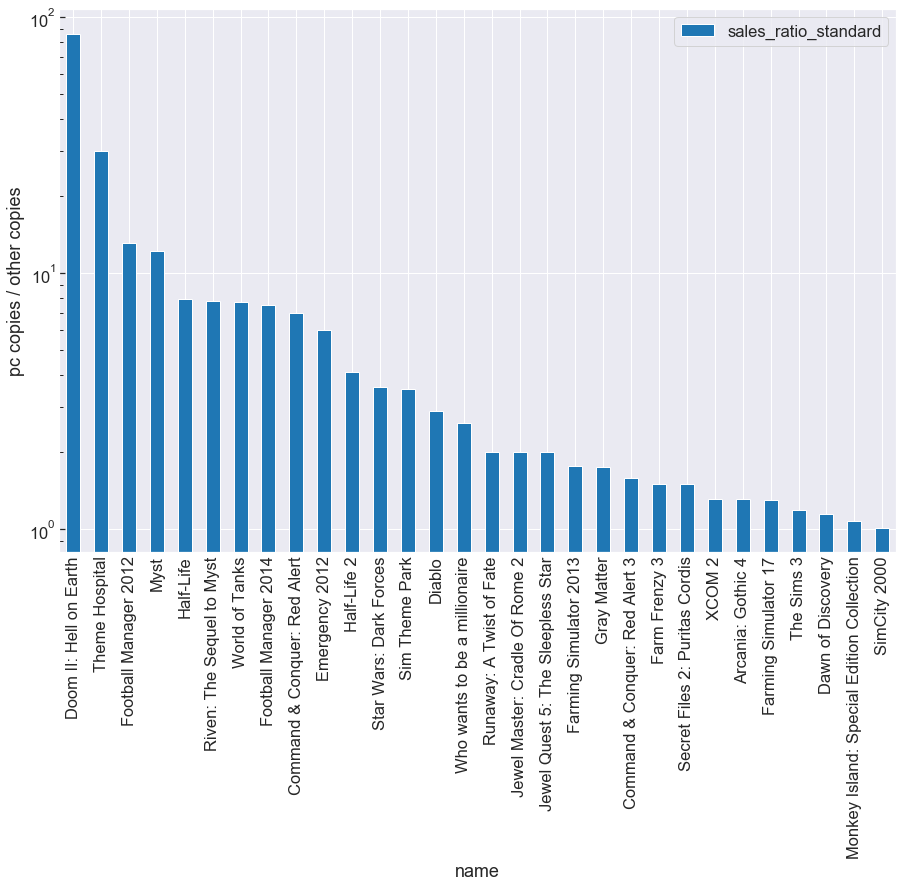

In [103]:
pc_outsale_df.plot(kind='bar', x='name', y='sales_ratio_standard',
                   logy=True, figsize=(15, 10), label=None)

plt.ylabel('pc copies / other copies')

plt.savefig('non_pc_ratio.png', dpi=300, bbox_inches='tight')

plt.show()

In [75]:
cloud_dict = pc_outsale_df.set_index('name').to_dict()['sales_ratio']

cloud_dict

{'The Sims 3': 1.437171284842641,
 'Half-Life': 17.97787744796671,
 'Doom II: Hell on Earth': 38.71518207490623,
 'Command & Conquer: Red Alert': 16.83809367695813,
 'Myst': 21.73956967774974,
 'Riven: The Sequel to Myst': 17.84189205380961,
 'Theme Hospital': 29.54242509439325,
 'Half-Life 2': 12.262979269871494,
 'SimCity 2000': 0.08557595958549982,
 'Sim Theme Park': 10.944226466412347,
 'Star Wars: Dark Forces': 11.070192011662343,
 'Who wants to be a millionaire': 8.25480933077052,
 'Diablo': 9.220688696524151,
 'Football Manager 2012': 22.35278995733601,
 'Farming Simulator 2013': 4.914543743941515,
 'Command & Conquer: Red Alert 3': 4.002589998462401,
 'Farming Simulator 17': 2.2646395415009914,
 'Football Manager 2014': 17.501225267834002,
 'Dawn of Discovery': 1.1598389395537347,
 'World of Tanks': 17.69213162595861,
 'XCOM 2': 2.36198624155989,
 'Arcania: Gothic 4': 2.330111381428742,
 'Monkey Island: Special Edition Collection': 0.6436936674280265,
 'Gray Matter': 4.86076097

In [76]:
from wordcloud import WordCloud

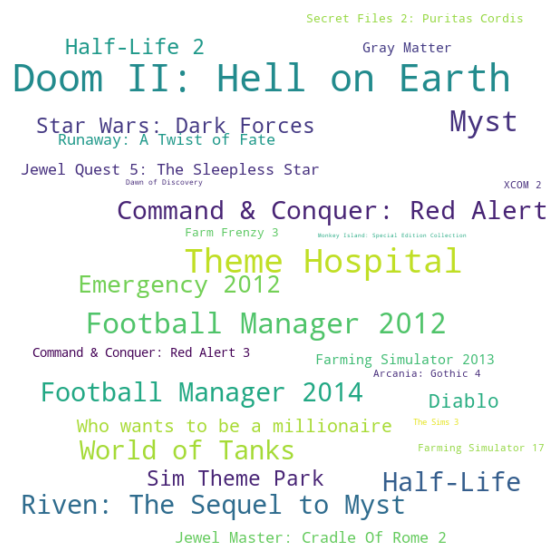

In [89]:
wc = WordCloud(width=600, height=600, max_words=500, background_color='white').generate_from_frequencies(cloud_dict)

fig = plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# fig.savefig('word_cloud.png', dpi=300, bbox_inches='tight')